In [3]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append('../')

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabasz_score, confusion_matrix

from models.CAE import CAE
from models.VCAE import VCAE
from generate import sin_cos, arma, wind
from train import train
from utils import latent_space, choose_bottleneck, compute_distance_matrix

import hydra
from hydra.experimental import initialize, compose

torch.manual_seed(4444)
np.random.seed(4444)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create Dataset

In [ ]:
with initialize(config_path="conf"):
    cfg = compose(config_name="config")

cfg_dataset, cfg_model, cfg_train = cfg.dataset, cfg.model, cfg.train

In [ ]:
n_train, n_valid, n_test = cfg_dataset.n_train, cfg_dataset.n_valid, cfg_dataset.n_test
n = n_train+n_valid+n_test

length = cfg_model.length # each observation is a vector of size (1,length)

## Generate documents

In [ ]:
#X = sin_cos(n, length)
#X = wind(num_elems=length)

X1 = arma(n//3, length, ar=[0, -0.5] , ma=[0, 0.1])
X2 = arma(n//3, length, ar=[0, 0, 0.7] , ma=[0, 0, 0.05])
X3 = arma(n//3, length, ar=[0, 0, 0, 0, -0.6] , ma=[0, 0, 0, 0, 0.2])
class1 = np.array([0]*(n//3), dtype=np.float32).reshape(n//3, 1, 1)
class2 = np.array([1]*(n//3), dtype=np.float32).reshape(n//3, 1, 1)
class3 = np.array([2]*(n//3), dtype=np.float32).reshape(n//3, 1, 1)
X1 = np.append(X1, class1, 2)
X2 = np.append(X2, class2, 2)
X3 = np.append(X3, class3, 2)

X = np.r_[X1,X2,X3]
Y = np.array([1]*len(X1) + [2]*len(X2) + [3]*len(X3))

idx = list(range(len(X)))
np.random.shuffle(idx)
X = X[idx]
Y = Y[idx]

X = torch.from_numpy(X)
print("shape of X:", X.shape)

X_train, X_valid, X_test = X[:n_train], X[n_train:n_train+n_valid], X[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y[:n_train], Y[n_train:n_train+n_valid], Y[n_train+n_valid:]
print("shape of X_train, X_valid, X_test:", X_train.shape, X_valid.shape, X_test.shape)

# Model

In [66]:
model = CAE(cfg_model)

## Train

In [60]:
train_losses, valid_losses = train(model, cfg_train, X_train, X_valid)

EPOCH 10 train loss: 2.110719747841358, valid loss: 2.1123144030570984
epochs without improvement: 0

EPOCH 20 train loss: 1.6116070821881294, valid loss: 1.6746090650558472
epochs without improvement: 0

EPOCH 30 train loss: 1.480522383004427, valid loss: 1.547464907169342
epochs without improvement: 0

EPOCH 40 train loss: 1.4161769673228264, valid loss: 1.4773923456668854
epochs without improvement: 0

EPOCH 50 train loss: 1.3743843995034695, valid loss: 1.4333930611610413
epochs without improvement: 0

EPOCH 60 train loss: 1.3425473123788834, valid loss: 1.4123242497444153
epochs without improvement: 2

EPOCH 70 train loss: 1.3185212686657906, valid loss: 1.367911547422409
epochs without improvement: 0

EPOCH 80 train loss: 1.2948826253414154, valid loss: 1.3630470633506775
epochs without improvement: 2

EPOCH 90 train loss: 1.275847151875496, valid loss: 1.3371573984622955
epochs without improvement: 1

EPOCH 100 train loss: 1.2638495862483978, valid loss: 1.3373693823814392
epoch

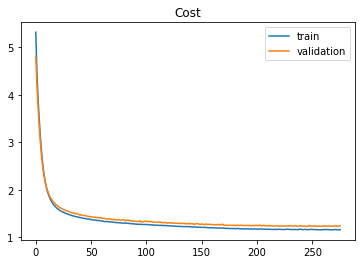

In [61]:
plt.title("Cost")
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="validation")
plt.legend()

## Load/Save model

In [ ]:
#torch.save(model.state_dict(), "../saved_weights/vcae_kl0.25")
#model.load_state_dict(torch.load("../saved_weights/vcae_kl0.25"))

# Testing

## Average and std correlation

avg and std: 0.015274267399267396 0.1295075565952436

cor: 0.052701465201465195
cor: 0.15851648351648348
cor: 0.2026098901098901
cor: -0.10032051282051281


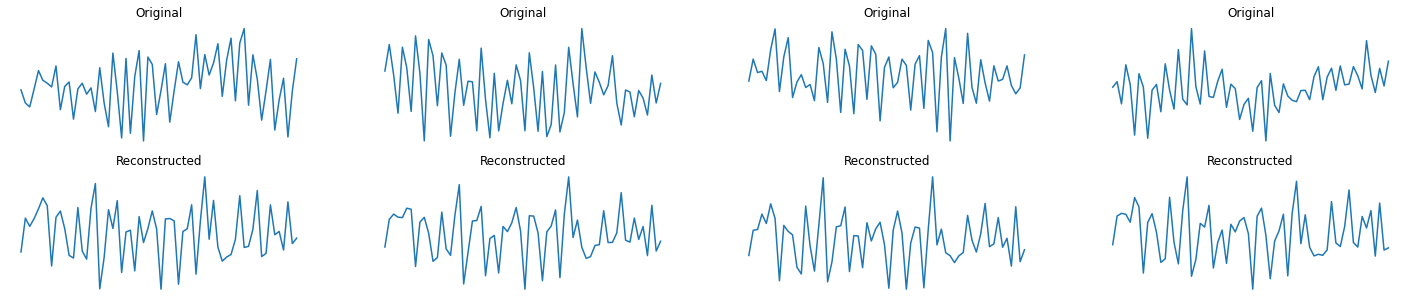

In [67]:
pred = model(X_test).detach().numpy()
inp = X_test[:,:,:-1]

# avg and std of cors
cors = [scipy.stats.spearmanr(pred[i,0], inp[i,0]).correlation for i in range(n_test)]
print("avg and std:", np.mean(cors), np.std(cors))
print()

# plots
n_plots = 4
start = n_plots*0

fig, axs = plt.subplots(nrows=2, ncols=n_plots, figsize=(25,5))
for i in range(n_plots):
    
    axs[0,i].axis("off")
    axs[0,i].set_title("Original")
    axs[0,i].plot(inp[start+i,0])

    axs[1,i].axis("off")
    axs[1,i].set_title("Reconstructed")
    axs[1,i].plot(pred[start+i,0])
    print("cor:", scipy.stats.spearmanr(pred[start+i,0], inp[start+i,0]).correlation)

# Latent space

In [ ]:
if cfg_model.bottleneck_nn == 2:
    latent_space(model, n=10)

# Choose bootleneck

In [ ]:
#vals = choose_bottleneck(X_test, X_train, X_valid, length, M, Lf)
#plt.plot([np.mean(x) for x in vals], "-o", [1]*len(vals))

# Checking important filters

In [ ]:
num_filter = 4*cfg_model.M
w_per_filter = cfg_model.length-cfg_model.Lf+1 # weights per filter
num_neurons = cfg_model.bottleneck_nn
M = cfg_model.M 

if isinstance(model, VCAE):
    num_neurons *= 2

w = np.array([[torch.mean(torch.abs(model.full1.weight[j,i*w_per_filter:(i+1)*w_per_filter])).item() for i in range(num_filter)] for j in range(num_neurons)])

x_axis_labels = [f"{i}-d:{2**(i//M)}" for i in range(w.shape[1])] # number of filter - d:dilatation
sns.heatmap(w, cmap="coolwarm", xticklabels=x_axis_labels) # y-axis => neuron of the bottleneck, x-axis => each position is one filter ordered by dilatation

# Clustering using bootlenecks

In [ ]:
bns = model(X_test, get_bottleneck=True).detach().numpy()
chs = []
for i in range(2,25):
    clustering = AgglomerativeClustering(n_clusters=i)
    clustering.fit(bns) 
    clus = clustering.labels_
    ch = calinski_harabasz_score(bns,clus)
    chs.append(ch)
plt.plot(range(2,len(chs)+2), chs, "o-")

In [ ]:
clustering = AgglomerativeClustering(n_clusters=3)
clustering.fit(bns)
clus = clustering.labels_

In [ ]:
if bns.shape[1] <= 10: # more than 10 plots is slow
    sns.pairplot(pd.DataFrame(np.c_[bns,clus]), hue=bns.shape[1])

In [ ]:
d1, d2 = 0, 1
sns.scatterplot(x=bns[:,d1], y=bns[:,d2], hue=clus)

In [ ]:
clus

In [ ]:
Y_test

In [ ]:
print(np.unique(Y_test[clus == 0], return_counts=True))
print(np.unique(Y_test[clus == 1], return_counts=True))
print(np.unique(Y_test[clus == 2], return_counts=True))

In [ ]:
clus += 1 # by exploration is the optimal option

In [ ]:
cm = confusion_matrix(Y_test, clus)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")

In [ ]:
mean, var = model(X_test, get_distribution=True)
mean, var = mean.detach().numpy(), var.detach().numpy()

In [ ]:
dm = compute_distance_matrix(mean, var, 1)

In [ ]:
# Complete: uses the maximum distances between all observations of the two sets.
print(AgglomerativeClustering(n_clusters=3, affinity="precomputed", linkage="complete").fit(dm).labels_)
print()
# Average: uses the average of the distances of each observation of the two sets.
print(AgglomerativeClustering(n_clusters=3, affinity="precomputed", linkage="average").fit(dm).labels_)
print()
# Single: uses the minimum of the distances between all observations of the two sets.
print(AgglomerativeClustering(n_clusters=3, affinity="precomputed", linkage="single").fit(dm).labels_)

In [ ]:
Y_test

In [ ]:
clus = AgglomerativeClustering(n_clusters=3, affinity="precomputed", linkage="complete").fit(dm).labels_
print(np.unique(Y_test[clus == 0], return_counts=True))
print(np.unique(Y_test[clus == 1], return_counts=True))
print(np.unique(Y_test[clus == 2], return_counts=True))

In [ ]:
clus = AgglomerativeClustering(n_clusters=3, affinity="precomputed", linkage="complete").fit(dm).labels_
clus += 1
cm = confusion_matrix(Y_test, clus)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")